In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt

data = pd.read_csv('C:/Users/Drew/Downloads/foot_traffic.csv')
data.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


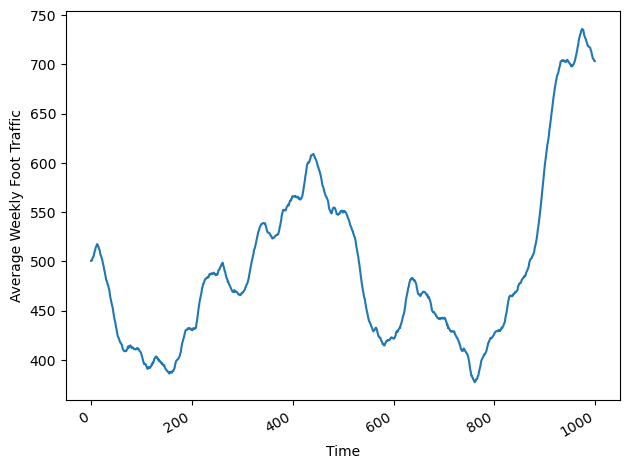

In [3]:
fig, ax = pt.subplots()

ax.plot(data['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average Weekly Foot Traffic')
fig.autofmt_xdate()
pt.tight_layout()

In [4]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(data['foot_traffic'])
print(f' ADF Statistic: {ADF_result[0]}')
print(f' P-Value: {ADF_result[1]}')

 ADF Statistic: -1.1758885999240796
 P-Value: 0.6838808917896169


In [5]:
foot_diff = np.diff(data['foot_traffic'], n=1)

In [6]:
ADF_result = adfuller(foot_diff)
print(f' ADF Statistic: {ADF_result[0]}')
print(f' P-Value: {ADF_result[1]}')

 ADF Statistic: -5.268231347422036
 P-Value: 6.3693176547815014e-06


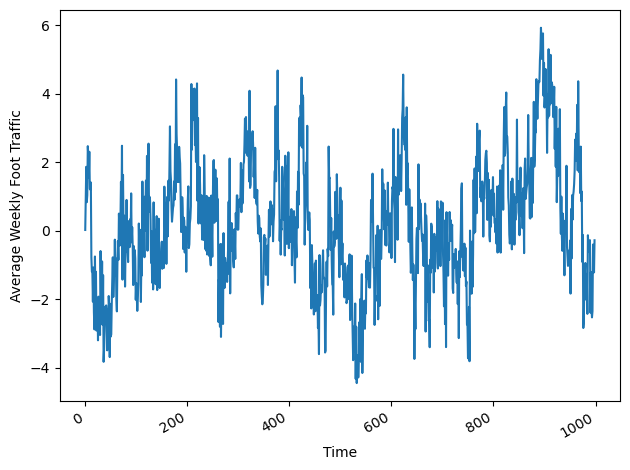

In [7]:
fig, ax = pt.subplots()

ax.plot(foot_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average Weekly Foot Traffic')
fig.autofmt_xdate()
pt.tight_layout()

In [8]:
data.describe()

,foot_traffic
count,1000.000000
mean,493.370272
std,87.573218
min,377.234968
25%,427.289387
50%,471.470980
75%,538.854388
max,736.065341


In [9]:
data_diff = pd.DataFrame({'foot_diff': foot_diff})

train = data_diff[:-199]
test = data_diff[-199:]

print(len(train))
print(len(test))

800
199


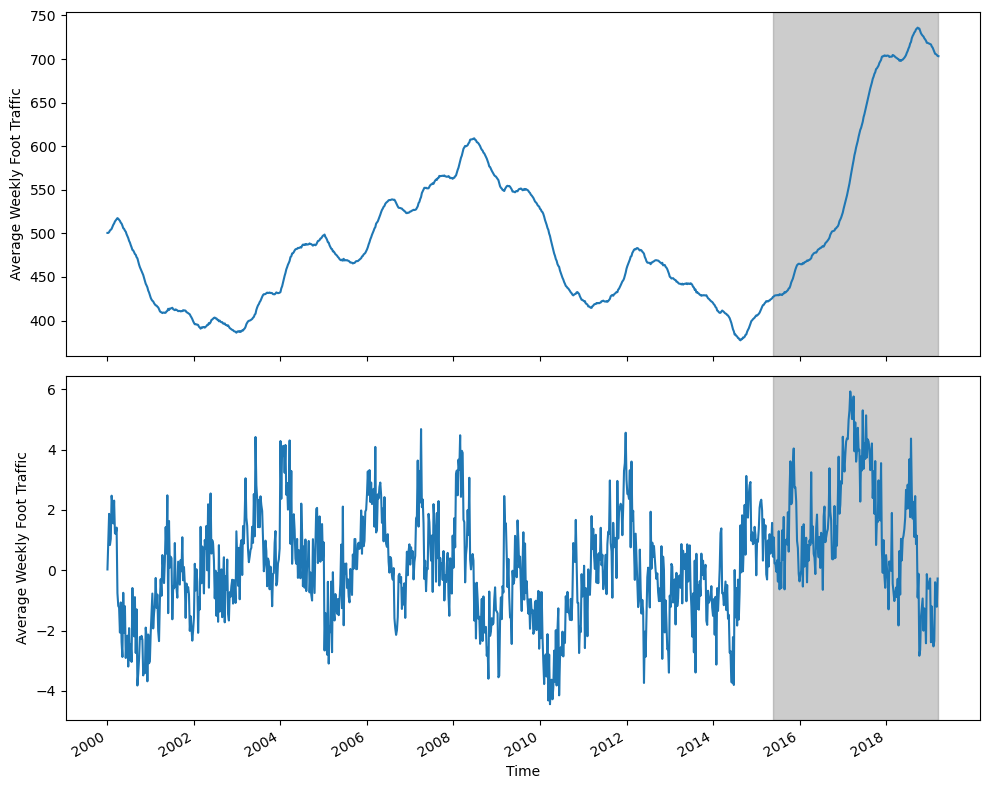

In [10]:
fig, (ax1, ax2) = pt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(data['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Average Weekly Foot Traffic')
ax1.axvspan(800, 999, color="#808080", alpha=0.4)

ax2.plot(data_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Average Weekly Foot Traffic')
ax2.axvspan(800, 999, color="#808080", alpha=0.4)

pt.xticks(np.arange(0,1000,104), np.arange(2000,2020,2))

fig.autofmt_xdate()
pt.tight_layout()

In [11]:
#Function to fit all unique ARMA(p,q) models
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    #Initialize an empty list to store the order (p,q) and its corresponding AIC as a tuple
    results = [] 
    
    #Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar.
    for order in tqdm(order_list): 
        try:
            #simple_differencing = False to prevent differencing
            #disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], 0, order[1]),
                            simple_differencing = False).fit(disp=False)
        except:
            continue
        
        aic = model.aic #Calculate the model's AIC
        results.append([order,aic]) #Append the (p,q) combination and AIC as a tuple to result list
    
    result_data = pd.DataFrame(results) #Store the combination in a DataFrame
    result_data.columns = ['(p,q)', 'AIC'] #Label the columns of the DataFrame
    
    #Sort in ascending order, lower AIC is better
    result_data = result_data.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_data

In [12]:
from itertools import product

ps = range(0,4,1) #Create a list of possible values for p starting from 0 inclusively to 4 exclusively, with steps of 1
qs = range(0,4,1) #Create a list of possible values of q starting from 0 inclusively to 4 exclusively, with steps of 1


order_list = list(product(ps, qs))

In [13]:
result_data = optimize_ARMA(train['foot_diff'], order_list)
result_data

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 1)",2248.709331
1,"(1, 3)",2249.772975
2,"(3, 2)",2250.697610
3,"(3, 0)",2251.471559
4,"(2, 3)",2251.745415
5,"(3, 3)",2251.979501
6,"(2, 1)",2252.933295
7,"(2, 2)",2253.014770
8,"(2, 0)",2257.167033
9,"(1, 2)",2260.414830


In [14]:
model = SARIMAX(data_diff, order=(3,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

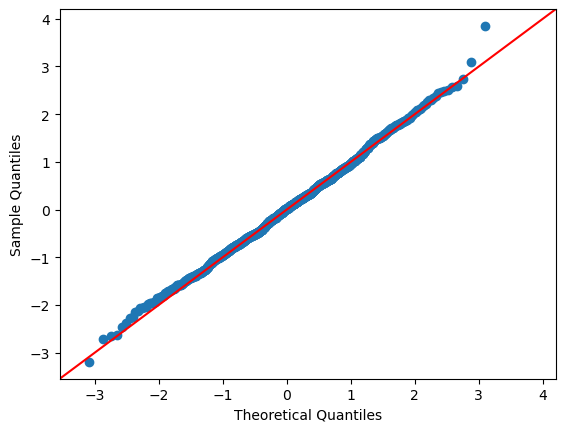

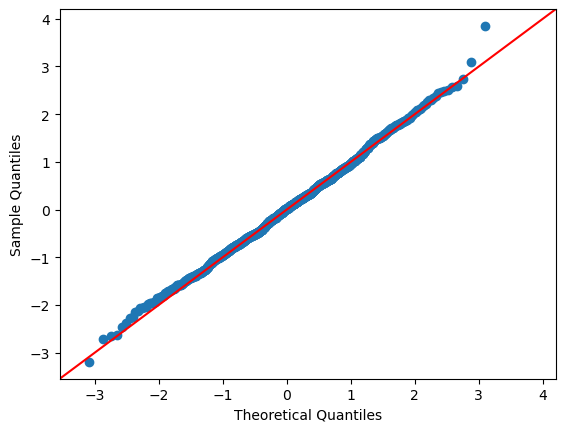

In [15]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45')

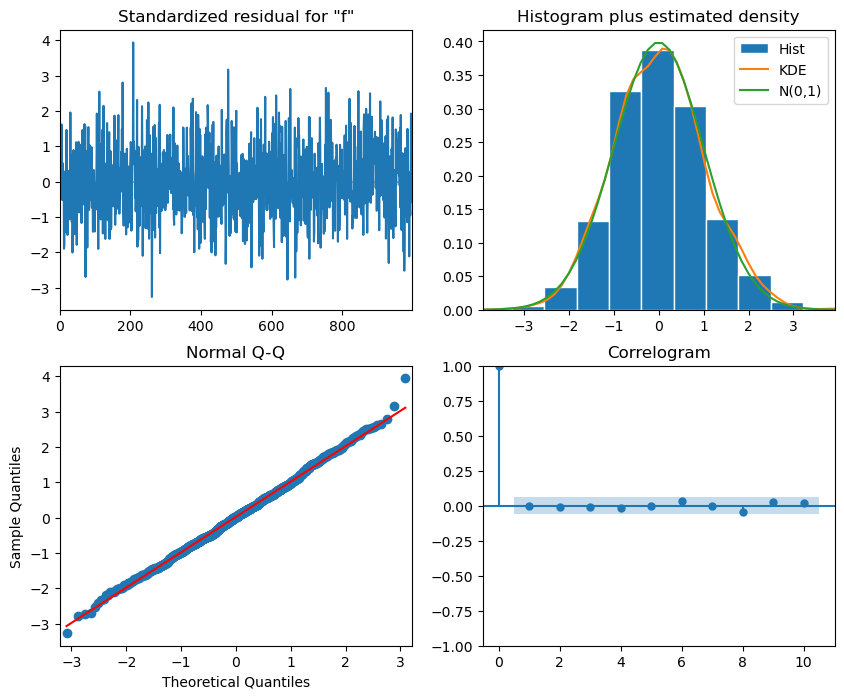

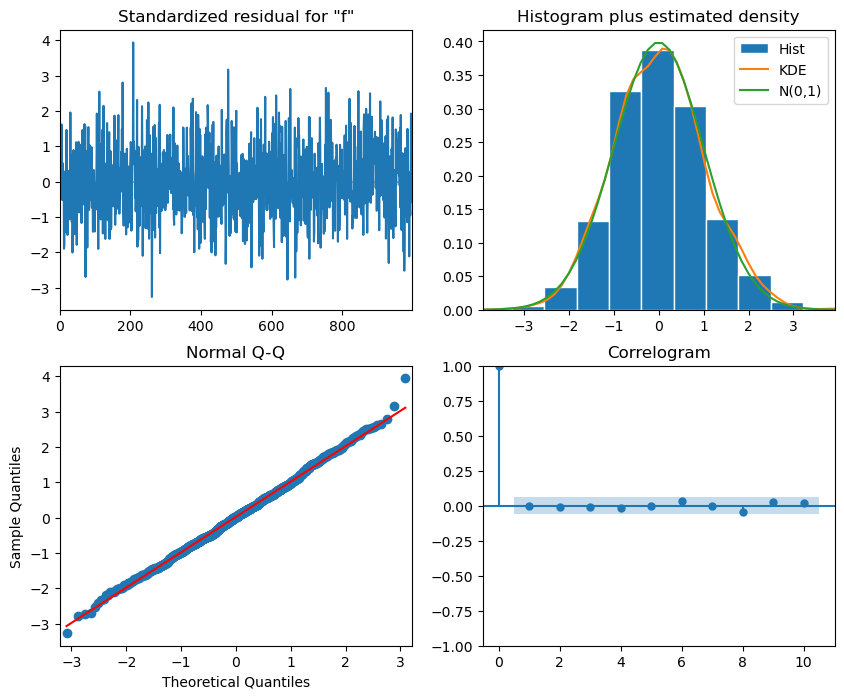

In [16]:
model_fit.plot_diagnostics(figsize=(10,8))

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

pvalue = acorr_ljungbox(residuals, np.arange(1,11,1))
print(pvalue)

     lb_stat  lb_pvalue
1   0.009789   0.921186
2   0.099778   0.951335
3   0.237516   0.971317
4   0.538952   0.969600
5   0.544201   0.990415
6   1.906098   0.928129
7   1.906235   0.964847
8   3.789793   0.875574
9   4.393463   0.883663
10  4.688345   0.911001


All lags have a p-value more than 0.05. We cannot reject the null hypothesis and can conclude that the residuals are uncorrelated and normally distributed.

# Ready for Forecasting

# Applying the General Modeling Procedure

- Gather data (done)
- Apply transformation if not stationary (done)
- List values of p and q (done)
- Fit every combination of ARMA(p,q) (done)
- Select model with the lowest AIC (done)
- Residual Analysis (done)
- Restart the process if Q-Q plot shows a straight line or There is uncorrelated residuals
- If everything is fine, ready to forecast 

In [29]:
#The function takes in a DataFrame containing the full simulated moving average process. 
#Train_len: have to pass in the length of training set
#Horizon: have to pass in the length of test set
#Window: How many timesteps we want to predict
#Method: the method we are using
def rolling_forecast(data: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'AR':
        pred_AR = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        return pred_AR

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (0,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

    elif method == 'ARMA':
        pred_ARMA= []
        for i in range(train_len, total_len, window):
            model = SARIMAX(data[:i], order = (3,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [30]:
pred_data = test.copy()
TRAIN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_ARMA = rolling_forecast(data_diff, TRAIN, HORIZON, WINDOW, 'ARMA')
pred_MA = rolling_forecast(data_diff, TRAIN, HORIZON, WINDOW, 'MA')
pred_AR = rolling_forecast(data_diff, TRAIN, HORIZON, WINDOW, 'AR')

pred_data['pred_ARMA'] = pred_ARMA
pred_data['pred_MA'] = pred_MA
pred_data['pred_AR'] = pred_AR

In [31]:
pred_data.head()

,foot_diff,pred_ARMA,pred_MA,pred_AR
800,0.449790,0.867367,0.525743,0.921045
801,1.086329,1.027233,-0.033046,0.966865
802,0.230934,0.661278,0.486930,0.697693
803,0.216362,0.601725,-0.111287,0.633873
804,-0.046263,0.302262,0.142452,0.282175


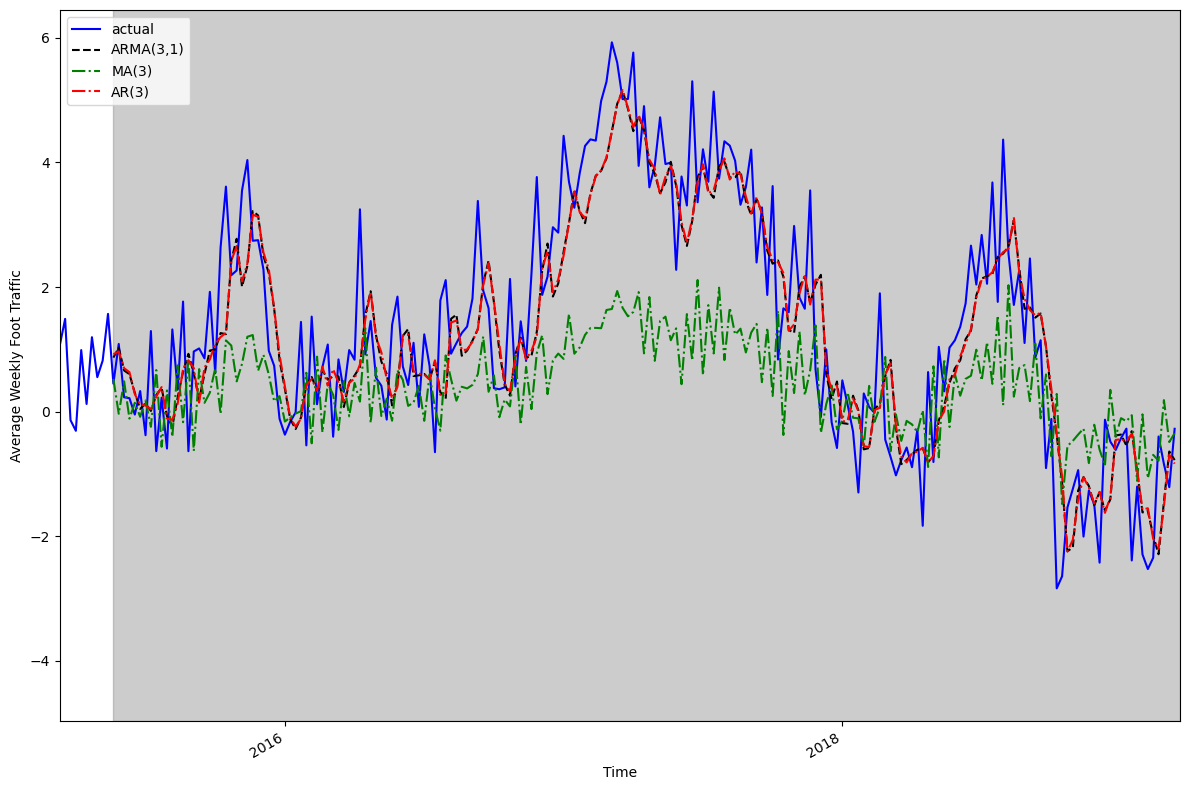

In [32]:
fig, ax = pt.subplots(figsize=(12,8))

ax.plot(data_diff['foot_diff'], 'b-', label='actual')
ax.plot(pred_data['pred_ARMA'], 'k--', label='ARMA(3,1)')
ax.plot(pred_data['pred_MA'], 'g-.', label='MA(3)')
ax.plot(pred_data['pred_AR'], 'r-.', label='AR(3)')
ax.set_xlabel('Time')
ax.set_ylabel('Average Weekly Foot Traffic')
ax.legend(loc=2)
ax.axvspan(800, 999, color="#808080", alpha=0.4)
pt.xticks(np.arange(0,1000,104), np.arange(2000,2020,2))
ax.set_xlim(790, 999)

fig.autofmt_xdate()
pt.tight_layout()

In [33]:
from sklearn.metrics import mean_squared_error

mean_ARMA = mean_squared_error(pred_data['foot_diff'], pred_data['pred_ARMA'])
mean_MA = mean_squared_error(pred_data['foot_diff'], pred_data['pred_MA'])
mean_AR = mean_squared_error(pred_data['foot_diff'], pred_data['pred_AR'])

print("The MSE of ARMA is : ", mean_ARMA)
print("The MSE of MA is : ", mean_MA)
print("The MSE of AR is : " , mean_AR)

The MSE of ARMA is :  0.9461985583917856
The MSE of MA is :  3.27371735812088
The MSE of AR is :  0.9342991681335678


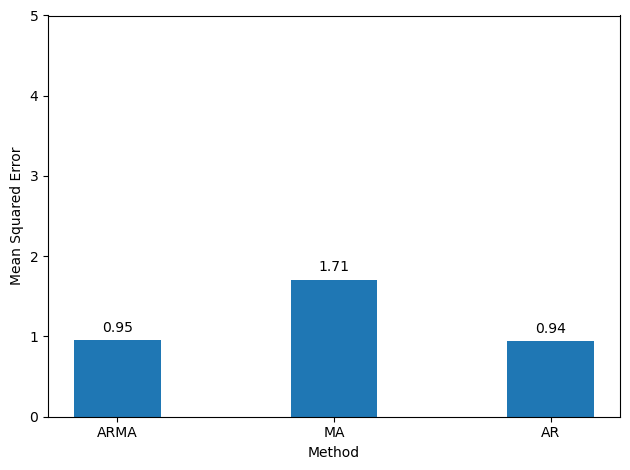

In [23]:
fig, ax = pt.subplots()

x = ['ARMA', 'MA', 'AR']
y = [0.95, 1.71 , 0.94]

ax.bar(x, y, width = 0.4)
ax.set_xlabel('Method')
ax.set_ylabel('Mean Squared Error')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    pt.text(x=index, y=value + 0.1, s=str(value), ha='center')

pt.tight_layout()

AR has the lowest MSE by 0.01 compared to ARMA. MA method is out of the question. Now let's transform it back to the original scale and perform MAE

In [24]:
data['pred_foot_traffic'] = pd.Series()
data['pred_foot_traffic_AR'] = pd.Series()
data['pred_foot_traffic_MA'] = pd.Series()

data['pred_foot_traffic'][801:] = data['foot_traffic'].iloc[801] + pred_data['pred_ARMA'].cumsum()
data['pred_foot_traffic_AR'][801:] = data['foot_traffic'].iloc[801] + pred_data['pred_AR'].cumsum()
data['pred_foot_traffic_MA'][801:] = data['foot_traffic'].iloc[801] + pred_data['pred_MA'].cumsum()

C:\Users\Drew\AppData\Local\Temp\ipykernel_11168\112187438.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_foot_traffic'][801:] = data['foot_traffic'].iloc[801] + pred_data['pred_ARMA'].cumsum()
C:\Users\Drew\AppData\Local\Temp\ipykernel_11168\112187438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pred_foot_traffic_AR'][801:] = data['foot_traffic'].iloc[801] + pred_data['pred_AR'].cumsum()
C:\Users\Drew\AppData\Local\Temp\ipykernel_11168\112187438.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

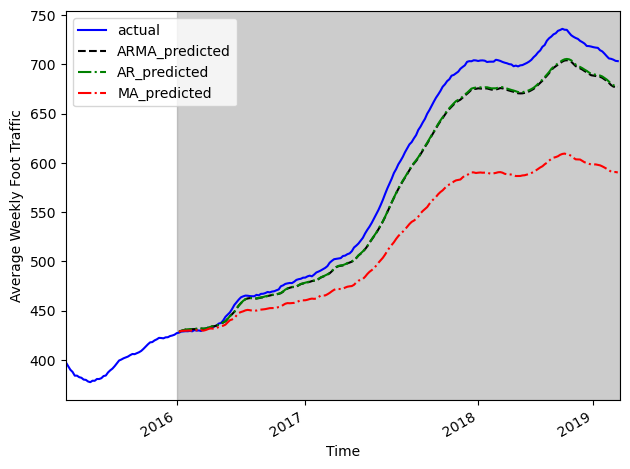

In [25]:
fig, ax = pt.subplots()

ax.plot(data['foot_traffic'], 'b-', label='actual')
ax.plot(data['pred_foot_traffic'], 'k--', label='ARMA_predicted')
ax.plot(data['pred_foot_traffic_AR'], 'g-.', label='AR_predicted')
ax.plot(data['pred_foot_traffic_MA'], 'r-.', label='MA_predicted')
ax.set_xlabel('Time')
ax.set_ylabel('Average Weekly Foot Traffic')
ax.legend(loc=2)
ax.axvspan(800, 1000, color="#808080", alpha=0.4)
ax.set_xlim(750,1000)
pt.xticks([800, 858, 936, 988], [2016,2017,2018,2019])
fig.autofmt_xdate()
pt.tight_layout()

In [26]:
from sklearn.metrics import mean_absolute_error

arma_MAE = mean_absolute_error(data['foot_traffic'][801:], data['pred_foot_traffic'][801:])
ar_MAE = mean_absolute_error(data['foot_traffic'][801:], data['pred_foot_traffic_AR'][801:])
ma_MAE = mean_absolute_error(data['foot_traffic'][801:], data['pred_foot_traffic_MA'][801:])

print("The MAE of ARMA is: ", arma_MAE)
print("The MAE of AR is: ", ar_MAE)
print("The MAE of MA is: ", ma_MAE)

The MAE of ARMA is:  18.401796603212883
The MAE of AR is:  17.75748566607218
The MAE of MA is:  67.06135598394572


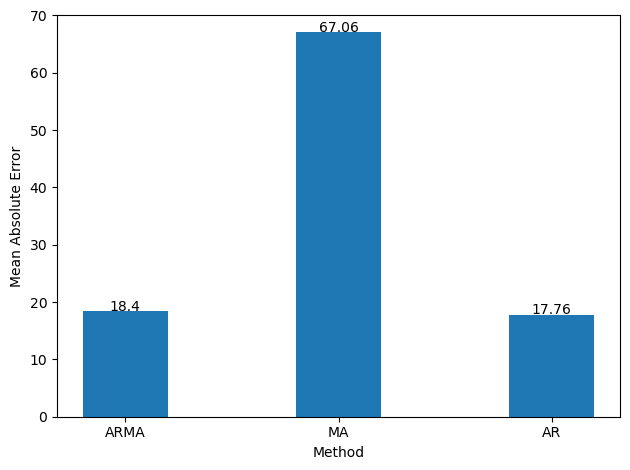

In [28]:
fig, ax = pt.subplots()

x = ['ARMA', 'MA', 'AR']
y = [18.4, 67.06 , 17.76]

ax.bar(x, y, width = 0.4)
ax.set_xlabel('Method')
ax.set_ylabel('Mean Absolute Error')
ax.set_ylim(0, 70)

for index, value in enumerate(y):
    pt.text(x=index, y=value + 0.1, s=str(value), ha='center')

pt.tight_layout()